In [583]:
import importlib
import hp
importlib.reload(hp)
from hp import look_df
from hp import check_dups

import mom 
importlib.reload(mom)

import pandas as pd
import os
import urllib.request
import tarfile
import numpy as np
import pandas_datareader
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

from IPython.display import display, Latex 

In [584]:
if not os.path.exists("data"):
    os.makedirs("data")
if not os.path.exists("data/DM"):
    os.makedirs("data/DM")

if not os.listdir("data/DM"):
    print('Downloading and extracting data...')
    thetarfile = "http://kentdaniel.net/data/momentum/DM_data_2017_03.tar.gz"
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(path="data/DM")

In [585]:
########################################################################
# Load daily momentum data
########################################################################
col_names = ['date', 'decile', 'ret', 'me', 'num']
dfMomDly = pd.read_csv('data/DM/d_m_pt_tot.txt', delimiter=r'\s+', header=None, names=col_names)
dfMomDly['date'] = pd.to_datetime(dfMomDly['date'], format='%Y%m%d')
dfMomDly = mom.calcLongShort(dfMomDly, bin_col='decile', return_col='ret')
dfMomDly = dfMomDly[dfMomDly['decile'] == 11].copy()
dfMomDly.reset_index(drop=True, inplace=True)
dfMomDly.drop(columns=['decile'], inplace=True)

########################################################################
# Calculate scaled volatility factor (columname  scldfctVol)
########################################################################
dfMomDly['ret2'] = dfMomDly['ret']**2
dfMomDly['rldsum'] = dfMomDly['ret2'].rolling(window=126).sum()
dfMomDly['rldsumMnth']= dfMomDly['rldsum'] / 126 * 21
dfMomDly['fcstdfVol'] = np.sqrt(dfMomDly['rldsum']) # forecasted vol
dfMomDly['scldfctVol'] = 0.12 / dfMomDly['fcstdfVol'] # scaled factor vol
dfVol = dfMomDly[['date', 'scldfctVol']].copy()
dfVol.dropna(inplace=True)
dfVol.reset_index(drop=True, inplace=True)
look_df(dfVol, 5)

Number of rows: 23,614
Number of columns: 2

First 5 rows:


,date,scldfctVol
0,1927-06-02,1.032954
1,1927-06-03,1.037766
2,1927-06-04,1.041746
3,1927-06-06,1.044220
4,1927-06-07,1.034296


In [586]:
########################################################################
# Calculate long short momentum portfolio monthly returns
########################################################################
# mom.loadStockMonthly(reload=True)
# mom.assignMomDeciles(reload=True)
dfMom = mom.calcMomDeciles(reload=False)
dfMom = mom.calcLongShort(dfMom, bin_col='DM_Decile', return_col='DM_Ret')
dfMomLS = dfMom[dfMom['DM_Decile'] == 11].copy()
dfMomLS.reset_index(drop=True, inplace=True)
dfMomLS.drop(columns=['DM_Decile'], inplace=True)
dfMomLS.rename(columns={'DM_Ret': 'momRet'}, inplace=True)
dfMomLSAll = dfMomLS.copy()
look_df(dfMomLS, 5)

Number of rows: 1,164
Number of columns: 2

First 5 rows:


,date,momRet
0,1927-01,0.030043
1,1927-02,-0.005318
2,1927-03,0.086889
3,1927-04,0.037577
4,1927-05,0.036419


In [587]:
########################################################################
# Select last date of each month to match monthly frequency
########################################################################
dfVol['period'] = dfVol['date'].dt.to_period('M')
last_dates_dfVol = dfVol.groupby('period')['date'].max().reset_index()
dfVolEOM = pd.merge(last_dates_dfVol, dfVol, on=['date', 'period'], how='left')
dfVolEOM.drop(columns=['date'], inplace=True)
dfVolEOM.rename(columns={'period': 'date'}, inplace=True)
dfVolEOM['date'] = dfVolEOM['date'] + 1 # need to shift date to match with mom data
look_df(dfVolEOM, 5)

Number of rows: 1,075
Number of columns: 2

First 5 rows:


,date,scldfctVol
0,1927-07,1.033845
1,1927-08,1.030880
2,1927-09,1.031423
3,1927-10,1.079664
4,1927-11,1.010692


In [588]:
########################################################################
# Merge momentum monthly return data and volatility scaling factor
########################################################################
dfMomLS = pd.merge(dfMomLS, dfVolEOM, on='date', how='inner')
dfMomLS['momRetScld'] = dfMomLS['momRet'] * dfMomLS['scldfctVol']
look_df(dfMomLS, 5)

Number of rows: 1,075
Number of columns: 4

First 5 rows:


,date,momRet,scldfctVol,momRetScld
0,1927-07,0.091263,1.033845,0.094352
1,1927-08,0.060550,1.030880,0.062420
2,1927-09,0.076771,1.031423,0.079183
3,1927-10,0.008860,1.079664,0.009565
4,1927-11,-0.066919,1.010692,-0.067635


In [589]:
########################################################################
# Calculate excess returns for both momRet and momRetScld
########################################################################
dfMomExcess = mom.calcExRet(df = dfMomLS, return_col = 'momRet', isDatePeriod=True) 
dfMomExcess = mom.calcExRet(df = dfMomExcess, return_col = 'momRetScld', isDatePeriod=True)
look_df(dfMomExcess, 5)
# dfMomExcess.to_csv('data/momExcess.csv', index=False)

/Users/kevinnecochea/Documents/edu/ucla/2024-spring/qam/HW/FP/mom.py:379: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
/Users/kevinnecochea/Documents/edu/ucla/2024-spring/qam/HW/FP/mom.py:379: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.


Number of rows: 1,075
Number of columns: 4

First 5 rows:


/Users/kevinnecochea/Documents/edu/ucla/2024-spring/qam/HW/FP/mom.py:379: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
/Users/kevinnecochea/Documents/edu/ucla/2024-spring/qam/HW/FP/mom.py:379: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.


,date,momRet,scldfctVol,momRetScld
0,1927-07,0.088263,1.033845,0.091352
1,1927-08,0.057750,1.030880,0.059620
2,1927-09,0.074671,1.031423,0.077083
3,1927-10,0.006360,1.079664,0.007065
4,1927-11,-0.069019,1.010692,-0.069735


In [590]:
########################################################################
# Calculate Statistics for both momRet and momRetScld
########################################################################

dd = mom.calculateStats(dfMomExcess, ['momRet', 'momRetScld'])
look_df(dd)
latex_table = dd.to_latex(index=False, float_format="%.2f", column_format="|c|c|c|")
print(latex_table)
display(Latex(latex_table))

Number of rows: 2
Number of columns: 5

First 5 rows:


,Excess_Return,Volatility,Sharpe_Ratio,Skewness,Kurtosis
momRet,14.122547,29.896932,0.472374,-1.996351,13.123510
momRetScld,20.149060,23.377840,0.861887,-0.452561,2.452277


\begin{tabular}{|c|c|c|}
\toprule
Excess_Return & Volatility & Sharpe_Ratio & Skewness & Kurtosis \\
\midrule
14.12 & 29.90 & 0.47 & -2.00 & 13.12 \\
20.15 & 23.38 & 0.86 & -0.45 & 2.45 \\
\bottomrule
\end{tabular}



<IPython.core.display.Latex object>

Number of rows: 23,739
Number of columns: 3

First 5 rows:


,date,ret,cumRet
0,1927-01-03,-0.01178,0.988220
1,1927-01-04,-0.01091,0.977439
2,1927-01-05,-0.01066,0.967019
3,1927-01-06,0.01035,0.977028
4,1927-01-07,0.00666,0.983535


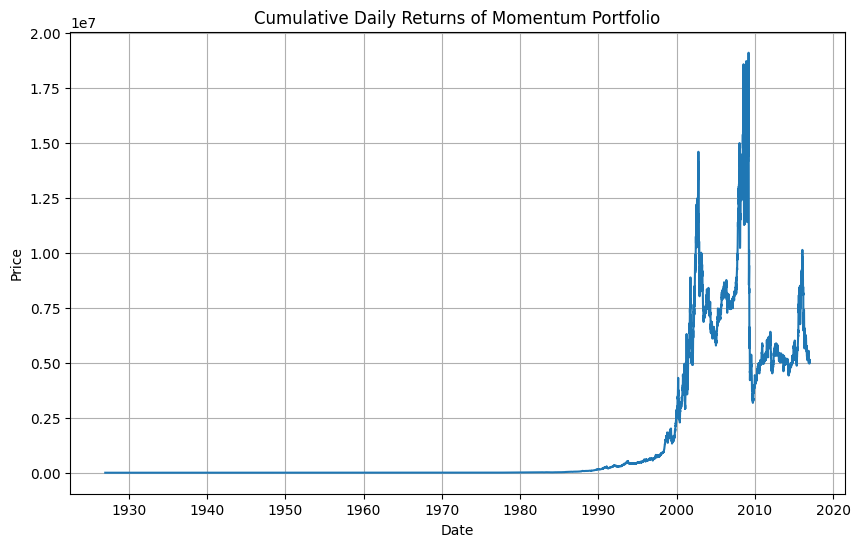

In [591]:
dfMomDlyRet = dfMomDly[['date', 'ret']].copy()
dfMomDlyRet['cumRet'] = (1 + dfMomDlyRet['ret']).cumprod()
look_df(dfMomDlyRet, 5)   

plt.figure(figsize=(10, 6))
sns.lineplot(data=dfMomDlyRet, x='date', y='cumRet')
# plt.plot(dfMomDlyRet['date'], dfMomDlyRet['cumRet'], color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cumulative Daily Returns of Momentum Portfolio')
plt.grid(True)
plt.show()


Max Drawdown:  -0.8336857174464103


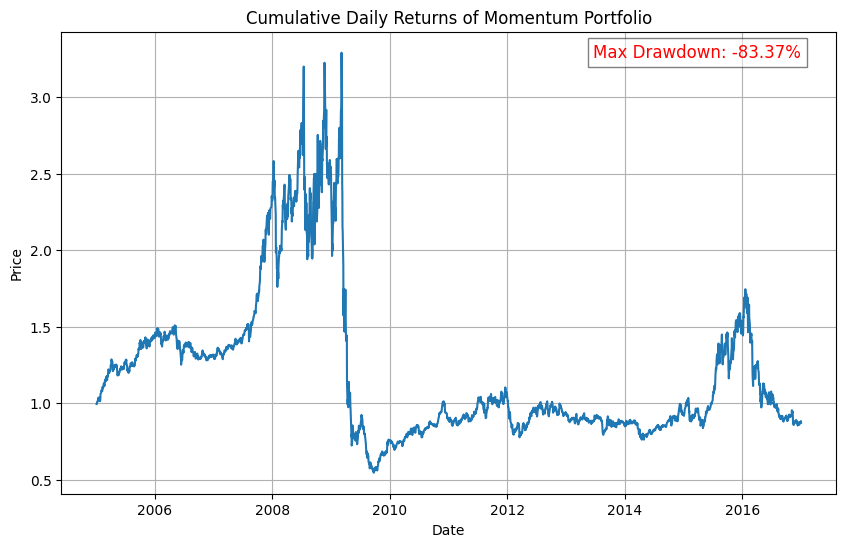

In [592]:
start_date = '2005-01-01'
end_date = '2017-12-31'

plt.figure(figsize=(10, 6))
dfMomDlyS = dfMomDly[(dfMomDly['date'] >= start_date) & (dfMomDly['date'] <= end_date)].copy()
drawdown = mom.calculateMaxDrawdown(dfMomDlyS, start_date = start_date, end_date = end_date, ret_col='ret')
print('Max Drawdown: ', drawdown)
dfMomDlySRet = dfMomDlyS[['date', 'ret']].copy()
dfMomDlySRet['cumRet'] = (1 + dfMomDlySRet['ret']).cumprod()
sns.lineplot(data=dfMomDlySRet, x='date', y='cumRet')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cumulative Daily Returns of Momentum Portfolio')

plt.text(dfMomDlySRet['date'].iloc[-1], dfMomDlySRet['cumRet'].max(), f'Max Drawdown: {drawdown:.2%}', 
        horizontalalignment='right', verticalalignment='center', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.show()



In [593]:
########################################################################
# Autoregressive (AR) model for volatility
########################################################################

dlyVol = dfMomDly[['date', 'ret2']].copy()
dlyVol['period'] = dlyVol['date'].dt.to_period('M')

monthlyVol = dlyVol.groupby('period')['ret2'].sum().reset_index()
monthlyVol['vol'] = np.sqrt(monthlyVol['ret2']) * 100

# Print the date range
min_date = monthlyVol['period'].min()
max_date = monthlyVol['period'].max()
print(f"Date range of the DataFrame: {min_date} to {max_date}")
look_df(monthlyVol)

# Autoregressive (AR) model
# Determine the appropriate lag length using AIC
ar_model = tsa.AutoReg(monthlyVol['vol'], lags=1, old_names=False).fit()

# Print model summary
print(ar_model.summary())


Date range of the DataFrame: 1927-01 to 2016-12
Number of rows: 1,080
Number of columns: 3

First 5 rows:


,period,ret2,vol
0,1927-01,0.001639,4.047848
1,1927-02,0.002038,4.513870
2,1927-03,0.003536,5.946544
3,1927-04,0.004499,6.707683
4,1927-05,0.001401,3.742841


                            AutoReg Model Results                             
Dep. Variable:                    vol   No. Observations:                 1080
Model:                     AutoReg(1)   Log Likelihood               -2611.012
Method:               Conditional MLE   S.D. of innovations              2.721
Date:                Sun, 02 Jun 2024   AIC                           5228.023
Time:                        00:52:09   BIC                           5242.975
Sample:                             1   HQIC                          5233.685
                                 1080                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3240      0.138      9.600      0.000       1.054       1.594
vol.L1         0.7644      0.020     38.945      0.000       0.726       0.803
                                    Roots           

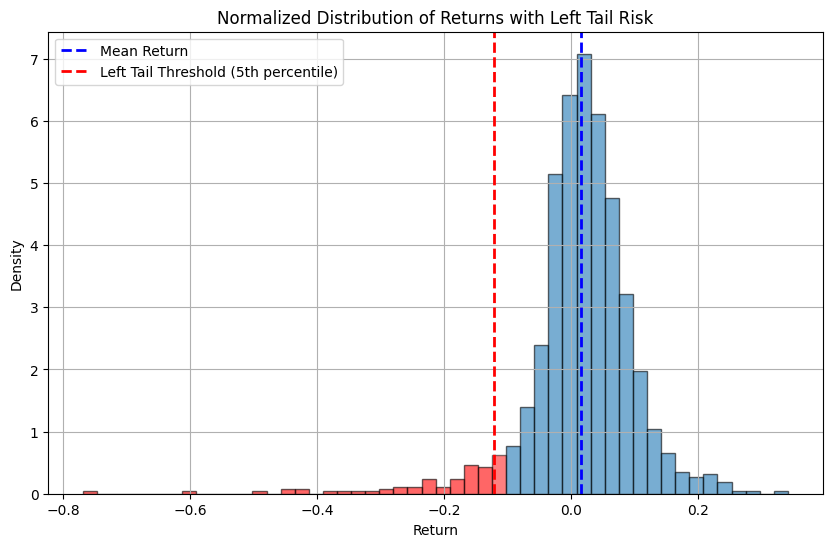

In [595]:
########################################################################
# Graph distribution of momentum portfolio returns
########################################################################

df = dfMomLSAll[['date', 'momRet']].copy()
df.rename(columns={'momRet': 'return'}, inplace=True)

# Calculate mean and percentile for threshold
mean_return = df['return'].mean()
left_tail_threshold = df['return'].quantile(0.05)  # 5th percentile

# Plotting the normalized distribution of returns
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['return'], bins=50, edgecolor='black', density=True, alpha=0.6)

# Highlight left tail risk area
for patch, left_side, right_side in zip(patches, bins[:-1], bins[1:]):
    if right_side < left_tail_threshold:
        patch.set_facecolor('red')
    elif left_side < left_tail_threshold < right_side:
        patch.set_facecolor('red')
        patch.set_alpha(0.5)

# Add vertical lines for mean and left tail threshold
plt.axvline(mean_return, color='blue', linestyle='dashed', linewidth=2, label='Mean Return')
plt.axvline(left_tail_threshold, color='red', linestyle='dashed', linewidth=2, label='Left Tail Threshold (5th percentile)')

# Labels and title
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Normalized Distribution of Returns with Left Tail Risk')
plt.legend()
plt.grid(True)
plt.show()

Number of rows: 1,080
Number of columns: 4

First 5 rows:


,period,ret2,vol,date
0,1927-01,0.001639,4.047848,1927-01-01
1,1927-02,0.002038,4.513870,1927-02-01
2,1927-03,0.003536,5.946544,1927-03-01
3,1927-04,0.004499,6.707683,1927-04-01
4,1927-05,0.001401,3.742841,1927-05-01


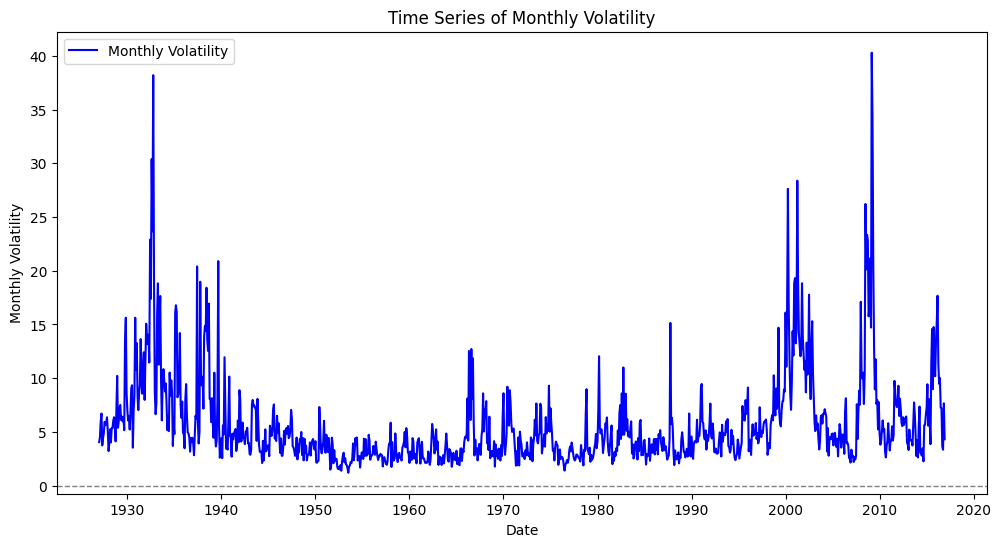

In [596]:
########################################################################
# Graph of monthly volatility of momentum portfolio returns
########################################################################

# Convert 'period' to datetime format
monthlyVol['date'] = monthlyVol['period'].dt.to_timestamp()
look_df(monthlyVol)

plt.figure(figsize=(12, 6))
plt.plot(monthlyVol['date'], monthlyVol['vol'], label='Monthly Volatility', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Monthly Volatility')
plt.title('Time Series of Monthly Volatility')
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)  # Adding a horizontal line at y=0
plt.legend()
plt.grid(False)
plt.show()


Number of rows: 23,614
Number of columns: 3

First 5 rows:


,date,scldfctVol,period
0,1927-06-02,1.032954,1927-06
1,1927-06-03,1.037766,1927-06
2,1927-06-04,1.041746,1927-06
3,1927-06-06,1.044220,1927-06
4,1927-06-07,1.034296,1927-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


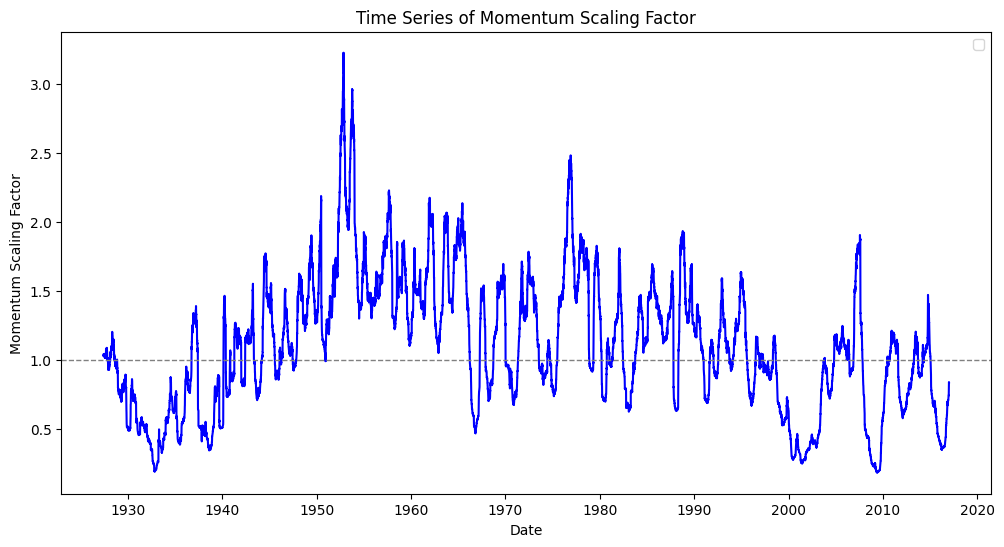

In [597]:
########################################################################
# Graph time series of momentum scaling factor
########################################################################

plt.figure(figsize=(12, 6))
plt.plot(dfVol['date'], dfVol['scldfctVol'], color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Momentum Scaling Factor')
plt.title('Time Series of Momentum Scaling Factor')
plt.axhline(y=1, color='grey', linestyle='--', linewidth=1)  # Adding a horizontal line at y=0
plt.legend()
plt.grid(False)
plt.show()

Number of rows: 145
Number of columns: 6

First 5 rows:


,date,momRet,momRetScld,period,pMom,pMomScld
930,2005-01-01,0.060368,0.067098,2005-01,1.060368,1.067098
931,2005-02-01,0.079834,0.090476,2005-02,1.145021,1.163645
932,2005-03-01,0.052570,0.057967,2005-03,1.205215,1.231098
933,2005-04-01,0.014475,0.015999,2005-04,1.222660,1.250795
934,2005-05-01,-0.025266,-0.026997,2005-05,1.191768,1.217027


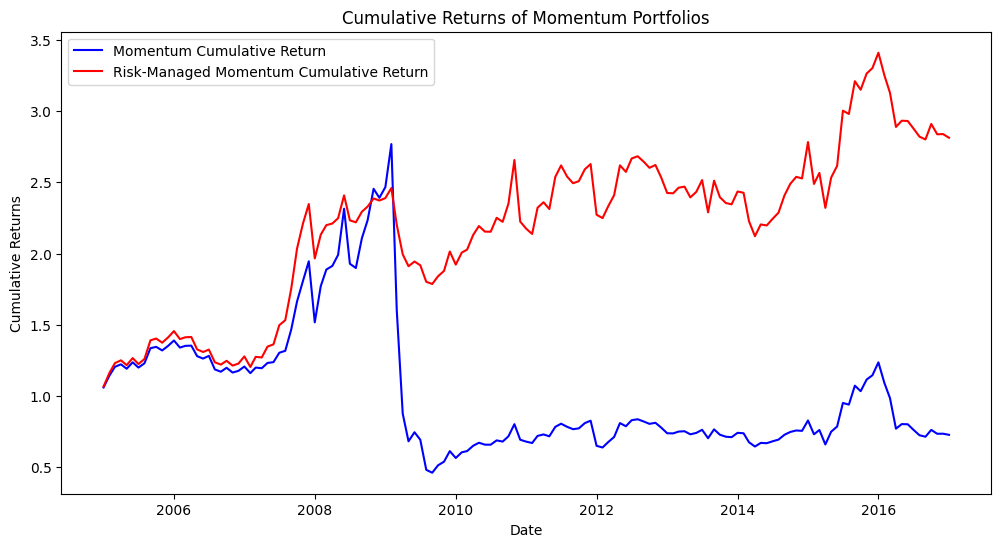

In [598]:
########################################################################
# Graph of performance of momentum and risk-managed momentum portfolios
########################################################################

perf = dfMomExcess[['date', 'momRet', 'momRetScld']].copy()
perf['date'] = perf['date'].dt.to_timestamp()
start_date = '2005-01-01'
end_date = '2017-12-31'
perf = perf[(perf['date'] >= start_date) & (perf['date'] <= end_date)].copy()

# Calculate cumulative returns
perf['pMom'] = (1 + perf['momRet']).cumprod()
perf['pMomScld'] = (1 + perf['momRetScld']).cumprod()

look_df(perf)

# Plotting the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(perf['date'], perf['pMom'], label='Momentum Cumulative Return', color='blue')
plt.plot(perf['date'], perf['pMomScld'], label='Risk-Managed Momentum Cumulative Return', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Momentum Portfolios')
plt.legend()
plt.grid(False)
plt.show()

In [603]:
########################################################################
# Regression on Fama French factors
########################################################################

rf_reader = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start='1926-01', end='2024-01')
rf = rf_reader.read()[0] / 100
rf.reset_index(inplace=True)
rf.rename(columns={'Date': 'date'}, inplace=True)

regTS = dfMomExcess[['date', 'momRet', 'momRetScld']].copy() # regression time series

regTS = pd.merge(regTS, rf, on='date', how='inner')
look_df(regTS)

# Set the independent variables (factors)
X = regTS[['Mkt-RF', 'SMB', 'HML']] * 100
# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Set the dependent variable (portfolio return)
y = regTS['momRetScld'] * 100

# Perform OLS regression
model = sm.OLS(y, X).fit()
print(model.summary())

Number of rows: 1,075
Number of columns: 7

First 5 rows:


/var/folders/t6/ng6664pn4gg67jzfmzw6vcch0000gn/T/ipykernel_95151/3613741847.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = rf_reader.read()[0] / 100
/var/folders/t6/ng6664pn4gg67jzfmzw6vcch0000gn/T/ipykernel_95151/3613741847.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = rf_reader.read()[0] / 100


,date,momRet,momRetScld,Mkt-RF,SMB,HML,RF
0,1927-07,0.088263,0.091352,0.0726,-0.0325,-0.0114,0.0030
1,1927-08,0.057750,0.059620,0.0197,-0.0069,-0.0374,0.0028
2,1927-09,0.074671,0.077083,0.0476,-0.0363,-0.0063,0.0021
3,1927-10,0.006360,0.007065,-0.0431,0.0212,-0.0433,0.0025
4,1927-11,-0.069019,-0.069735,0.0658,0.0272,-0.0027,0.0021


                            OLS Regression Results                            
Dep. Variable:             momRetScld   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     38.70
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           9.62e-24
Time:                        01:01:12   Log-Likelihood:                -3522.1
No. Observations:                1075   AIC:                             7052.
Df Residuals:                    1071   BIC:                             7072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9801      0.198     10.004      0.0